# **Chatbot With BERT | EDA + Vis**




## **1. Introduction**

Chatbots adalah program bertenaga AI yang mensimulasikan percakapan manusia. Mereka dapat menjawab pertanyaan, melakukan tugas, dan berinteraksi dengan pengguna, menjadikan teknologi lebih mudah diakses dan efisien. berikut langkah-langkahnya :

1.   Load the data
2.   EDA and analyze the data for more insights
3.   Split the data into train, test and validation datasets
4.   Load BERT Pretrained model and tokenizer
5.   Transform the data to numerical format
6.   Train BERT Pretrained model on our custome dataset
7.   Evaluate the model
8.   Save the model
9.   Finally, Load The model and start the conversation


## **2. Import Necessaries**





In [144]:
!pip install accelerate -U
!pip install nltk
!pip install wordcloud
!pip install missingno

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [145]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [147]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

## **3. EDA + Vis**

### **3.1 Load the data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [148]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("erdiansyah31/dataset-v-2")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dataset-v-2


In [149]:
import json
import os

# Path dari kagglehub
path = kagglehub.dataset_download("erdiansyah31/dataset-v-2")
json_file = os.path.join(path, "dataset_chatbot.json")

def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

try:
    intents = load_json_file(json_file)
    print("Dataset loaded successfully:", intents)
except FileNotFoundError:
    print(f"File {json_file} tidak ditemukan. Periksa path dan struktur dataset.")


Dataset loaded successfully: {'intents': [{'tag': 'greeting', 'patterns': ['hallo', 'hai', 'halo', 'hei', 'hi', 'hy', 'pagi', 'morning', 'siang', 'afternoon', 'sore', 'malam', 'bro', 'sis', 'kawan', '???', 'pagi'], 'responses': ['Halo!', 'Hai, yang di sana!', 'Salam!', 'Ada yang bisa saya bantu?', 'Bagaimana cara membantu Anda hari ini?', 'Hai! Tokpedbot di sini. Mau tau informasi tentang apa nih?', 'Halo! Saya Tokpedbot, salam kenal ya! Mau tau tentang Tokopedia, kan?', 'Helo! Ini Tokpedbot. Lagi kepo tentang Tokopedia ya?'], 'context_set': ''}, {'tag': 'goodbye', 'patterns': ['Selamat tinggal', 'Sampai jumpa lagi', 'Selamat tinggal', 'Dah', 'Dadah', 'Bye', 'Byee', 'Good bye', 'Bai', 'See you'], 'responses': ['Selamat tinggal!', 'Sampai jumpa lagi!', 'Hati-hati di jalan!', 'Bye!', 'Dadahh!', 'Good bye!', 'Dahh, semoga harimu menyenangkan yaa!', 'Sampai jumpa lagi!', 'See u! Senang bisa membantu'], 'context_set': ''}, {'tag': 'terimakasih', 'patterns': ['Thanks', 'Thank you', 'Terima k

### **3.2  Extract Info from the Json data file and Store it in dataframe**

In [150]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [151]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:
        # Periksa apakah kunci 'tag' ada sebelum mengaksesnya
        if 'tag' in intent:
            for pattern in intent['patterns']:
                sentence_tag = [pattern, intent['tag']]
                df.loc[len(df.index)] = sentence_tag
        else:
            print(f"Peringatan: Kunci 'tag' tidak ditemukan di dalam intent: {intent}")  # Cetak peringatan untuk debugging

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [152]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


### **3.3 Check the shape of the dataset**

In [153]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 721 rows and 2 columns


### **3.4 Display information about the dataset**

In [154]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 0 to 720
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  721 non-null    object
 1   Tag      721 non-null    object
dtypes: object(2)
memory usage: 16.9+ KB
None


### **3.5 Display Number of Classes**

In [155]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 164 classes


### **3.6  Check the null values in the dataset**

In [156]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


### **3.7 Visualize the Null Values**

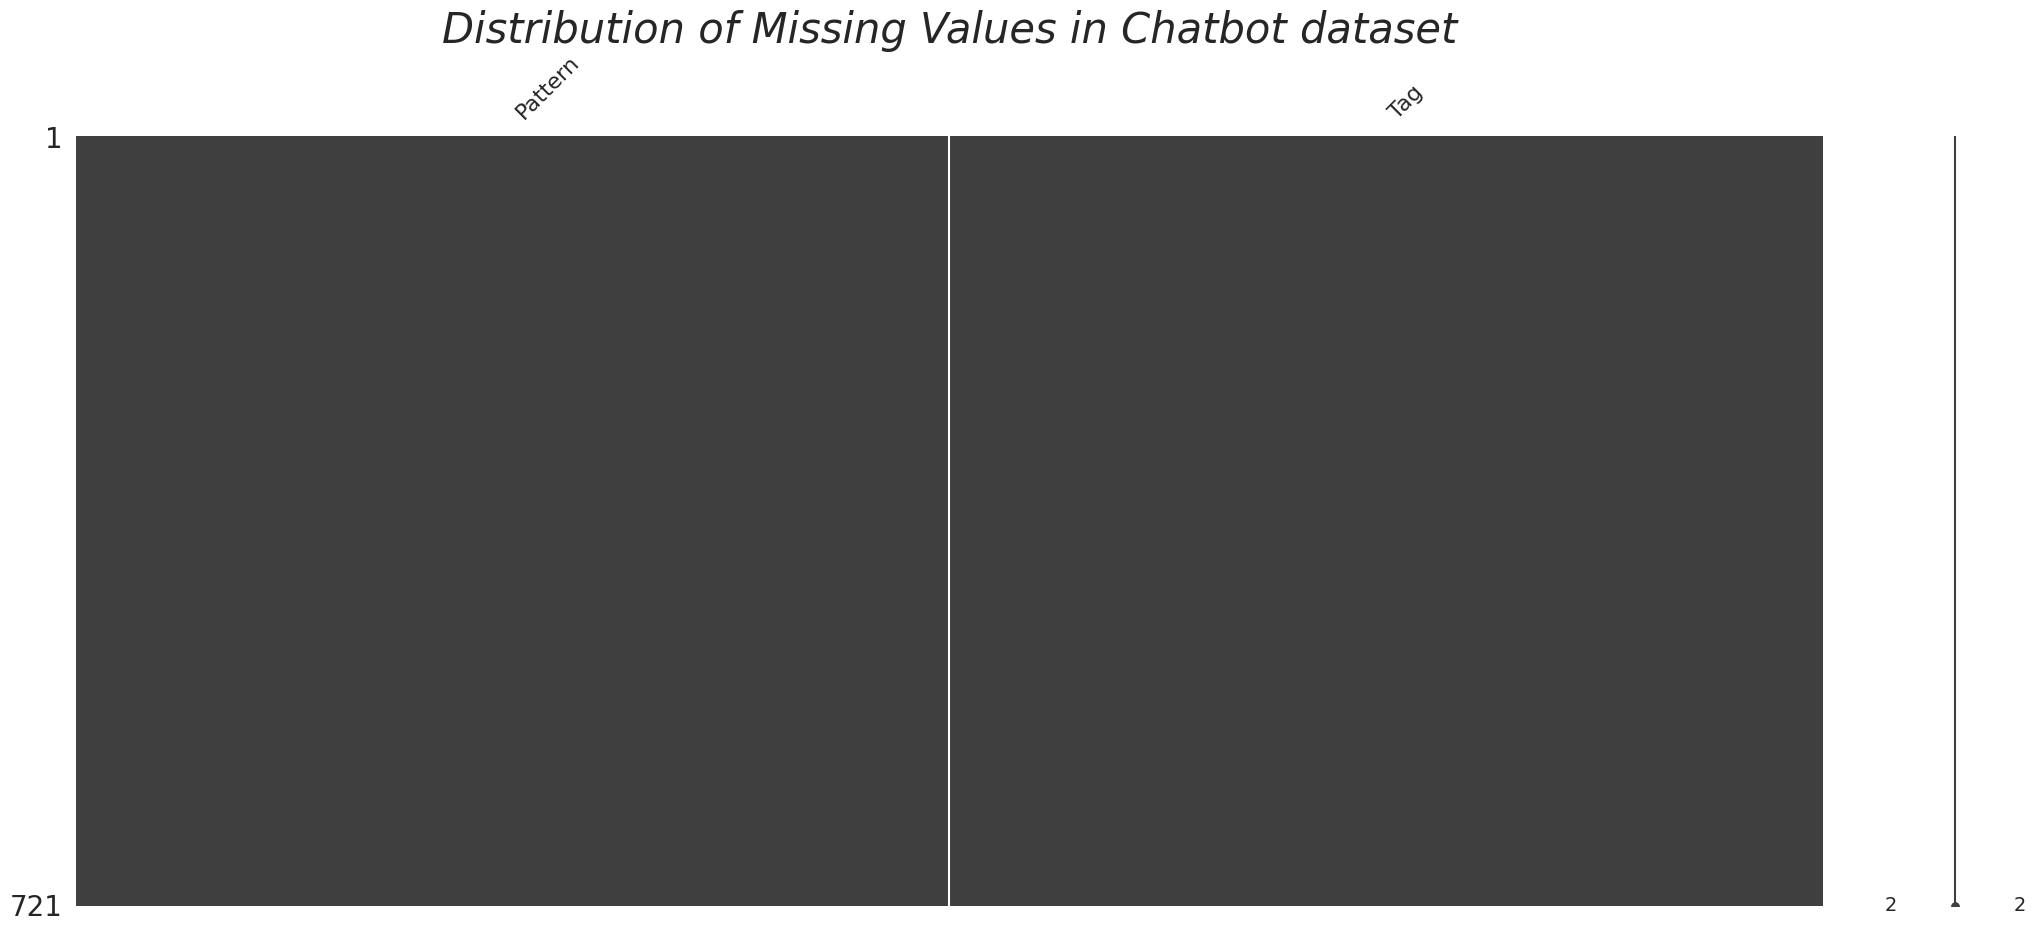

In [157]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

### **3.8 Visualize the distrbution of our Classe**

In [158]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

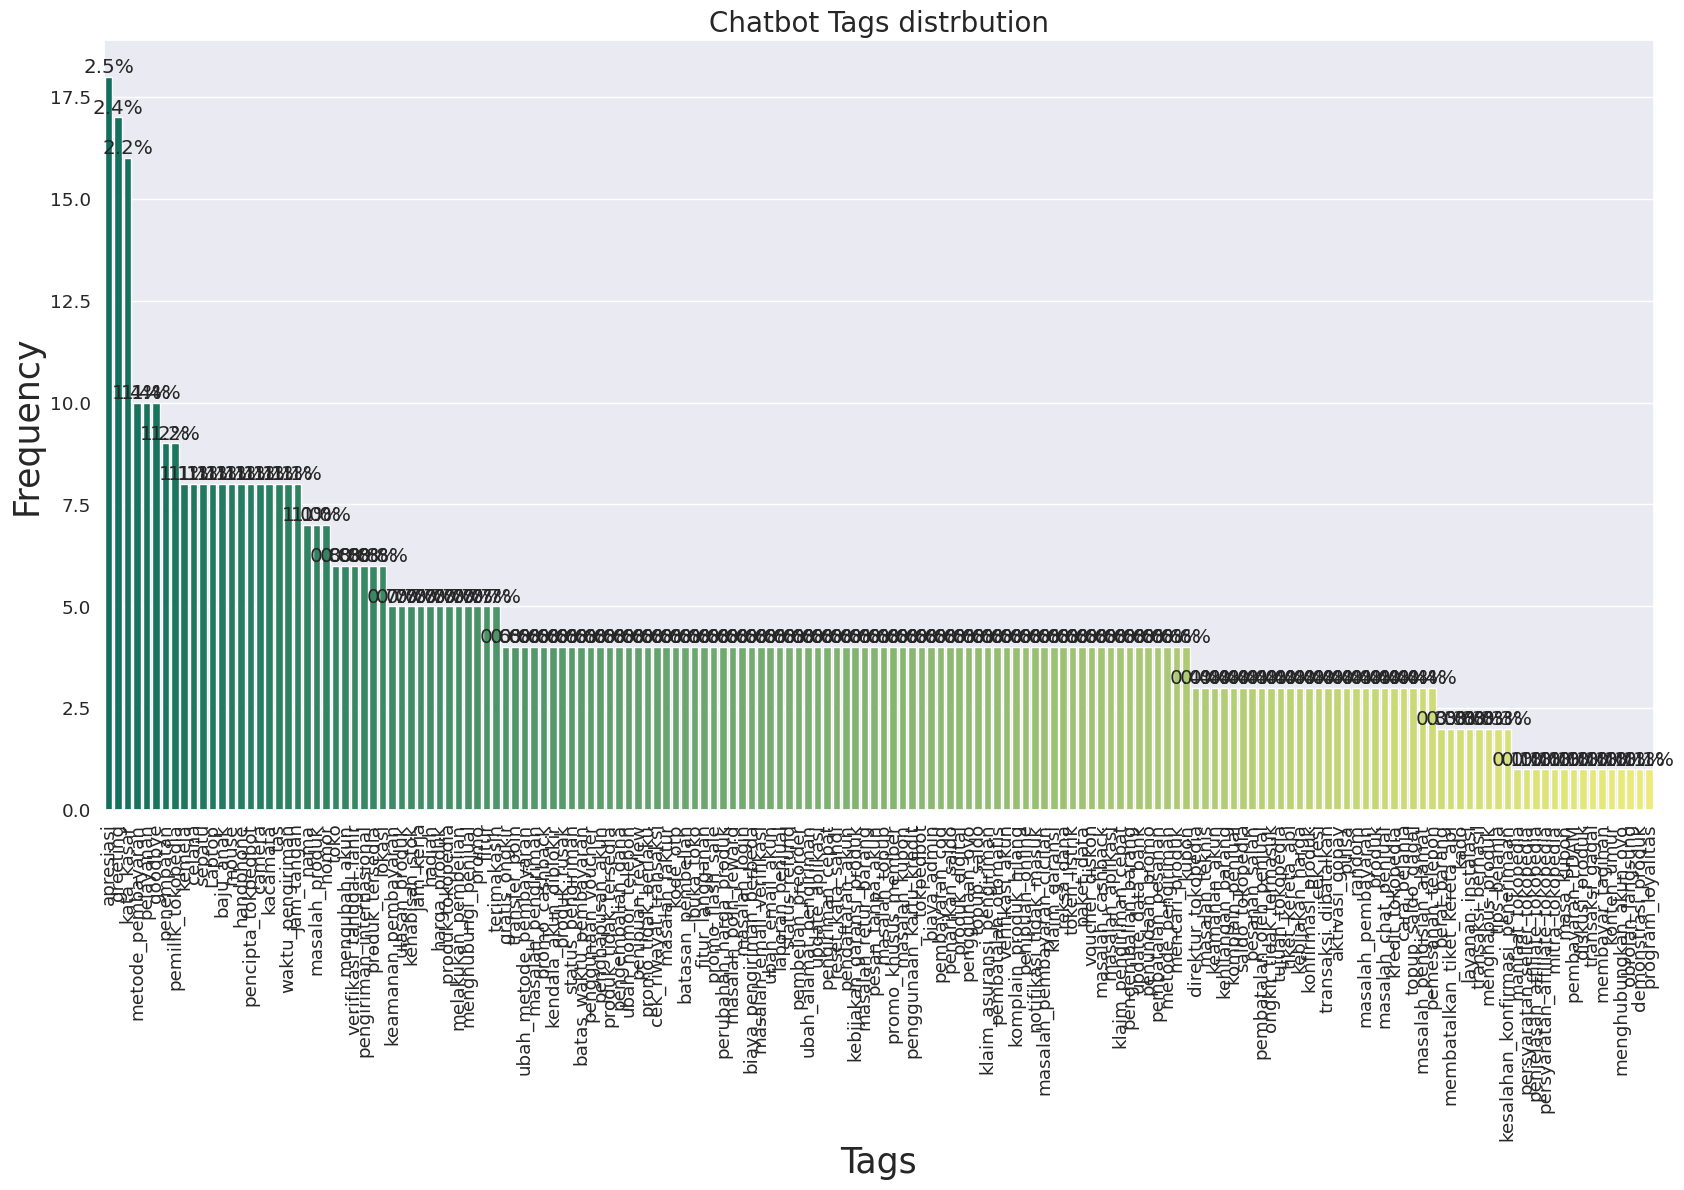

In [159]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [160]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [161]:
df.head()

,Pattern,Tag
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


### **3.9 Display Word Cloud**

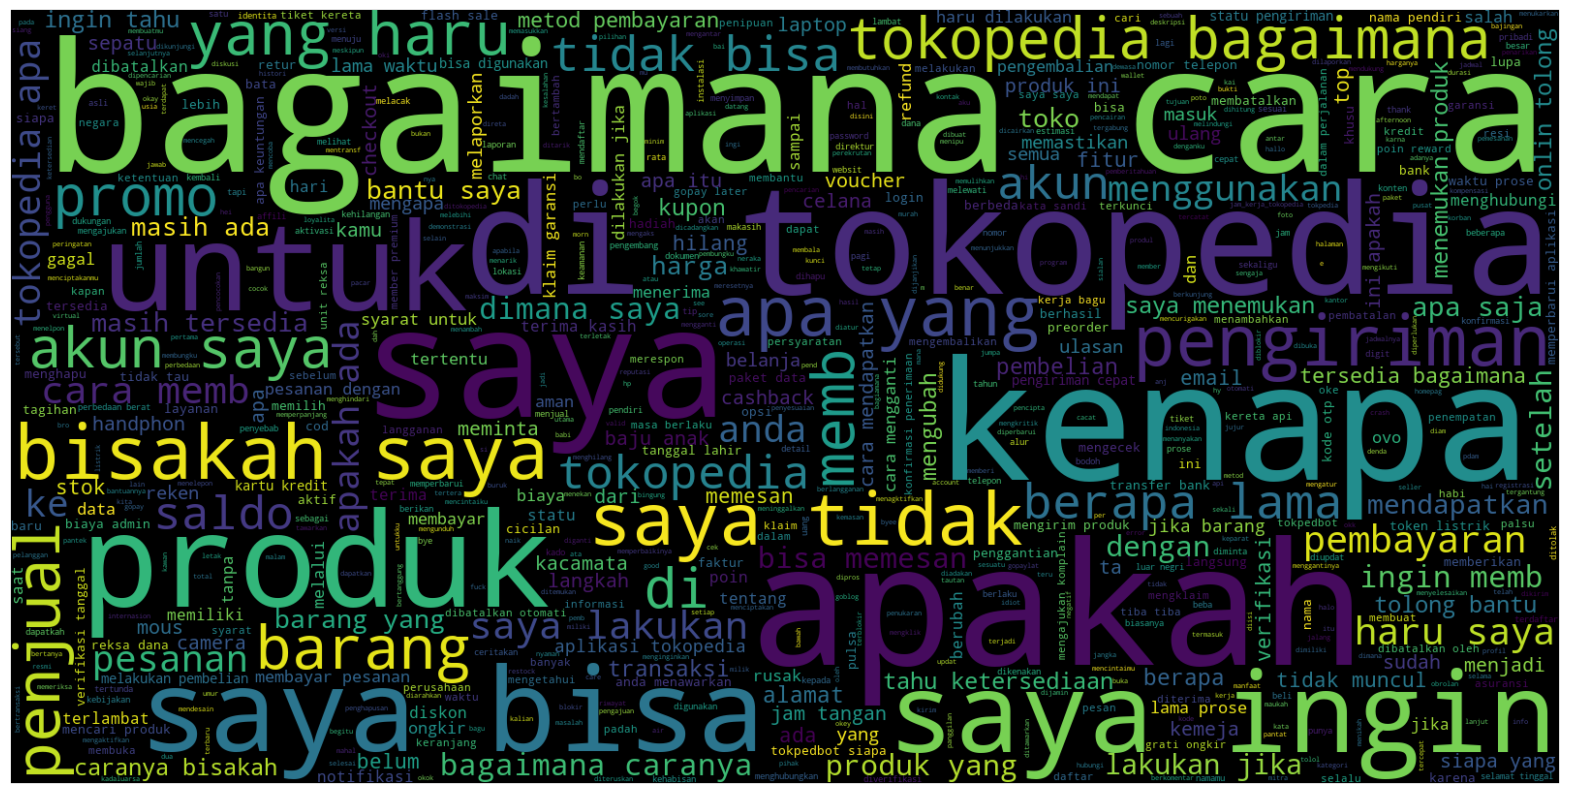

In [162]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

### **3.10 Distrbution of Number of letters in each text**

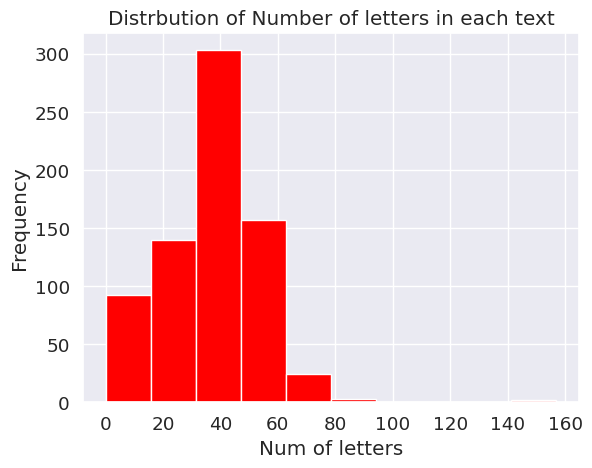

In [163]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

### **3.11 Distrbution of Number of words in each text**

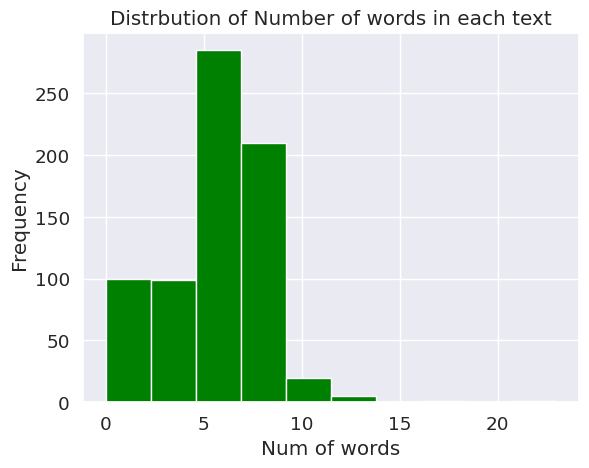

In [164]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

### **3.12 Visualize Average word length in each tex**

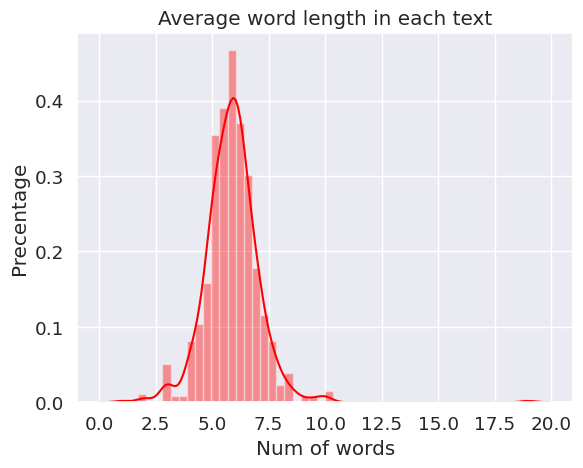

In [165]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

### **3.13 Visualize top words**

In [166]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hallo', 'hai', 'halo', 'hei', 'hi']

In [167]:
print(f"dataset contains {len(corpus)} words")

dataset contains 3995 words


In [168]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'saya': 328,
 'bagaimana': 143,
 'tokopedia': 133,
 'cara': 116,
 'apakah': 114,
 'yang': 95,
 'produk': 92,
 'di': 91,
 'kenapa': 86,
 'bisa': 84}

In [169]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

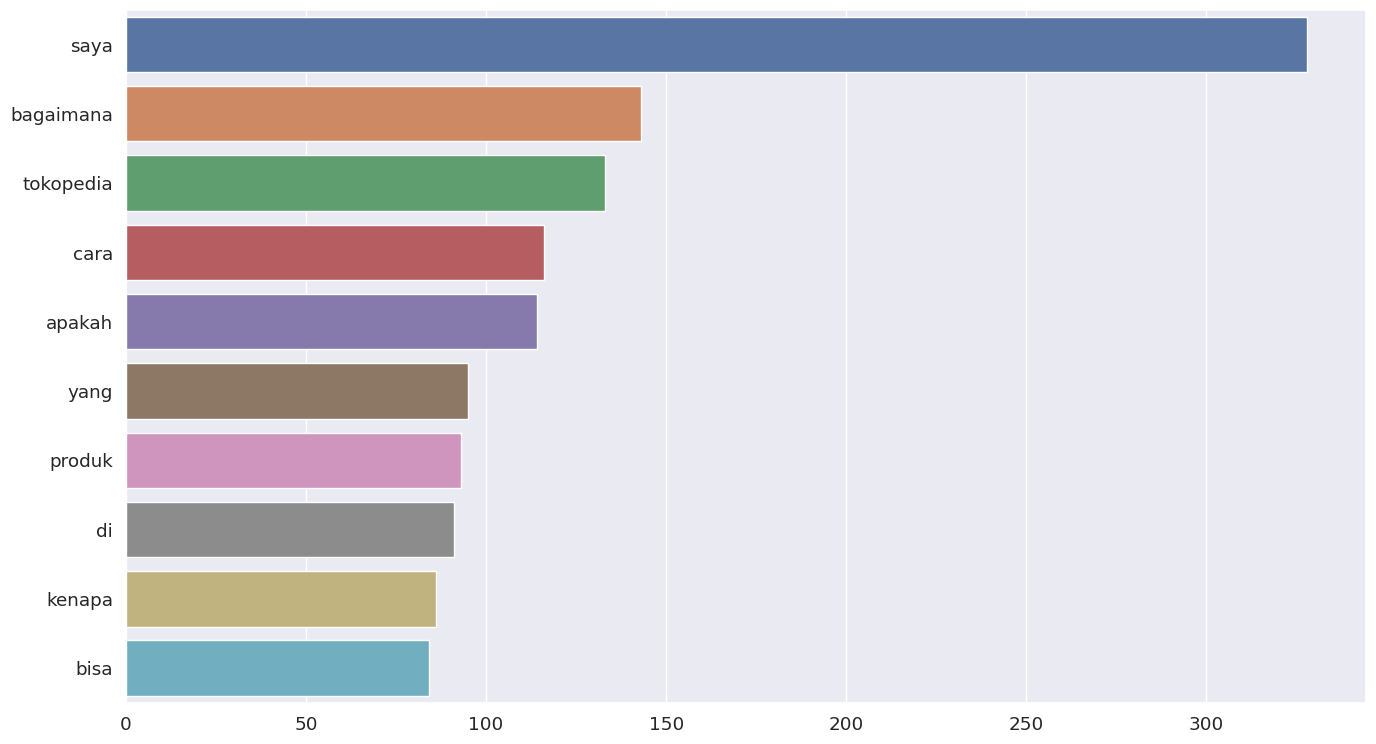

In [170]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

## **4. Data Preprocessing**

In [171]:
df2.head()

,Pattern,Tag
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [172]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'terimakasih',
 'tokpedbot',
 'pelayanan',
 'pencipta_tokpedbot',
 'direktur_tokopedia',
 'nama',
 'jam_kerja',
 'nomor',
 'produk tokopedia',
 'harga_produk',
 'lokasi',
 'promo',
 'toko',
 'fitur',
 'penempatan',
 'pemilik_tokopedia',
 'random',
 'kata_kasar',
 'apresiasi',
 'metode_pembayaran',
 'pendaftaran_akun',
 'reset_kata_sandi',
 'voucher_diskon',
 'waktu_pengiriman',
 'pengiriman_internasional',
 'kado',
 'kebijakan_harga',
 'pemesanan_telepon',
 'keamanan_pembayaran',
 'program_loyalitas',
 'pesan_tanpa_akun',
 'ulasan_produk',
 'kehabisan_stok',
 'obrolan_langsung',
 'hadiah',
 'layanan_instalasi',
 'demonstrasi_produk',
 'produk_tersedia',
 'camera',
 'handphone',
 'Laptop',
 'mouse',
 'celana',
 'kemeja',
 'sepatu',
 'kacamata',
 'tas',
 'jam_tangan',
 'baju_anak',
 'melakukan_pembelian',
 'mengubah_akun',
 'cara_belanja',
 'menghapus_produk',
 'mencari_produk',
 'konten_umur',
 'verifikasi_tanggal_lahir',
 'tips_belanja',
 'konfirmasi_produk',


In [173]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [174]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'terimakasih',
 3: 'tokpedbot',
 4: 'pelayanan',
 5: 'pencipta_tokpedbot',
 6: 'direktur_tokopedia',
 7: 'nama',
 8: 'jam_kerja',
 9: 'nomor',
 10: 'produk tokopedia',
 11: 'harga_produk',
 12: 'lokasi',
 13: 'promo',
 14: 'toko',
 15: 'fitur',
 16: 'penempatan',
 17: 'pemilik_tokopedia',
 18: 'random',
 19: 'kata_kasar',
 20: 'apresiasi',
 21: 'metode_pembayaran',
 22: 'pendaftaran_akun',
 23: 'reset_kata_sandi',
 24: 'voucher_diskon',
 25: 'waktu_pengiriman',
 26: 'pengiriman_internasional',
 27: 'kado',
 28: 'kebijakan_harga',
 29: 'pemesanan_telepon',
 30: 'keamanan_pembayaran',
 31: 'program_loyalitas',
 32: 'pesan_tanpa_akun',
 33: 'ulasan_produk',
 34: 'kehabisan_stok',
 35: 'obrolan_langsung',
 36: 'hadiah',
 37: 'layanan_instalasi',
 38: 'demonstrasi_produk',
 39: 'produk_tersedia',
 40: 'camera',
 41: 'handphone',
 42: 'Laptop',
 43: 'mouse',
 44: 'celana',
 45: 'kemeja',
 46: 'sepatu',
 47: 'kacamata',
 48: 'tas',
 49: 'jam_tangan',
 50: 'b

In [175]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'terimakasih': 2,
 'tokpedbot': 3,
 'pelayanan': 4,
 'pencipta_tokpedbot': 5,
 'direktur_tokopedia': 6,
 'nama': 7,
 'jam_kerja': 8,
 'nomor': 9,
 'produk tokopedia': 10,
 'harga_produk': 11,
 'lokasi': 12,
 'promo': 13,
 'toko': 14,
 'fitur': 15,
 'penempatan': 16,
 'pemilik_tokopedia': 17,
 'random': 18,
 'kata_kasar': 19,
 'apresiasi': 20,
 'metode_pembayaran': 21,
 'pendaftaran_akun': 22,
 'reset_kata_sandi': 23,
 'voucher_diskon': 24,
 'waktu_pengiriman': 25,
 'pengiriman_internasional': 26,
 'kado': 27,
 'kebijakan_harga': 28,
 'pemesanan_telepon': 29,
 'keamanan_pembayaran': 30,
 'program_loyalitas': 31,
 'pesan_tanpa_akun': 32,
 'ulasan_produk': 33,
 'kehabisan_stok': 34,
 'obrolan_langsung': 35,
 'hadiah': 36,
 'layanan_instalasi': 37,
 'demonstrasi_produk': 38,
 'produk_tersedia': 39,
 'camera': 40,
 'handphone': 41,
 'Laptop': 42,
 'mouse': 43,
 'celana': 44,
 'kemeja': 45,
 'sepatu': 46,
 'kacamata': 47,
 'tas': 48,
 'jam_tangan': 49,
 'baju_

In [176]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,hallo,greeting,0
1,hai,greeting,0
2,halo,greeting,0
3,hei,greeting,0
4,hi,greeting,0


## **5. Split the data into train and test**

In [177]:
X = list(df2['Pattern'])
X[:5]

['hallo', 'hai', 'halo', 'hei', 'hi']

In [178]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## **6. Load BERT Pretrained model and Tokenizer**

In [180]:
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [181]:
# Inisialisasi tokenizer dan model
model_name = "indolem/indobert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)

num_labels = len(id2label)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
# Aktifkan gradient checkpointing untuk mengurangi konsumsi memori
model.gradient_checkpointing_enable()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [182]:
class CustomBERTModel(nn.Module):
    def __init__(self, bert_model, num_labels, dropout_rate=0.3):  # Dropout increased
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs['last_hidden_state'][:, 0, :]  # Use CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

## **7. Transform the data into numerical formatt**

In [183]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [184]:
full_data = tokenizer(X, truncation=True, padding=True)

## **8. Build Data Loader**

In [185]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [186]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [187]:
fullDataLoader = DataLoader(full_data, y_test)

## **9. Define Evaluation Metrcies**

In [189]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

## **10. Define Training Arguments**

In [195]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=70,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,  # Gradient clipping
    logging_strategy='steps',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True,
    fp16=True,
)

In [196]:
#Menggunakan cross-validation

from sklearn.model_selection import StratifiedKFold
from transformers import Trainer

skf = StratifiedKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training Fold {fold + 1}")

    # Subset data berdasarkan fold
    X_train, X_val = [X[i] for i in train_index], [X[i] for i in val_index]
    y_train, y_val = [y[i] for i in train_index], [y[i] for i in val_index]

# Tokenisasi ulang berdasarkan fold
    train_encodings = tokenizer(X_train_fold, truncation=True, padding=True, max_length=max_len)
    val_encodings = tokenizer(X_val_fold, truncation=True, padding=True, max_length=max_len)


Training Fold 1
Training Fold 2
Training Fold 3
Training Fold 4
Training Fold 5


## **11. Train the model**

In [197]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop after 3 epochs without improvement

)

In [198]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.188400,1.679513,0.655172,0.500270,0.492767,0.538522
100,0.138900,1.601082,0.675862,0.539629,0.538301,0.571314
150,0.080600,1.649236,0.689655,0.538469,0.536378,0.572115
200,0.047000,1.719948,0.675862,0.525969,0.521955,0.564103
250,0.032700,1.740018,0.689655,0.541595,0.545556,0.573016
300,0.025900,1.756215,0.682759,0.530484,0.531270,0.563492
350,0.022200,1.782253,0.675862,0.527314,0.530503,0.555818
400,0.021400,1.768763,0.675862,0.525969,0.521955,0.564103
450,0.019300,1.805516,0.675862,0.525969,0.521955,0.564103
500,0.019200,1.798946,0.682759,0.526992,0.521746,0.561905


TrainOutput(global_step=630, training_loss=0.05124217025817387, metrics={'train_runtime': 188.5525, 'train_samples_per_second': 213.84, 'train_steps_per_second': 3.341, 'total_flos': 664004272619520.0, 'train_loss': 0.05124217025817387, 'epoch': 70.0})

## **12. Evaluate the mode**

In [199]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.016197,0.994792,0.996675,0.997016,0.996700
test,1.798946,0.682759,0.526992,0.521746,0.561905


In [200]:
def predict(text):

    # Ensure inputs are on the same device as the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(model.device)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [201]:
text = "Hello"
predict(text)

(tensor([[9.9865e-01, 1.5189e-04, 2.9967e-05, 1.7634e-05, 4.0635e-06, 8.4237e-06,
          8.2286e-06, 2.1333e-05, 1.3691e-06, 3.8727e-06, 2.2984e-06, 2.9154e-06,
          1.8014e-06, 9.4780e-06, 5.6776e-06, 3.9713e-06, 8.1447e-06, 3.1678e-06,
          9.4157e-06, 4.9215e-05, 6.1850e-05, 6.0949e-06, 6.7711e-06, 4.9593e-06,
          6.2656e-06, 1.4503e-06, 5.5317e-07, 3.5184e-06, 3.5064e-06, 6.1783e-06,
          2.1772e-06, 2.6275e-06, 5.3577e-06, 3.1354e-06, 5.3872e-06, 2.3541e-06,
          3.4085e-06, 1.3317e-05, 7.0417e-06, 2.9599e-06, 6.1896e-06, 2.4925e-06,
          5.9010e-06, 5.8760e-06, 3.2907e-06, 4.7981e-05, 1.6612e-06, 5.4661e-06,
          6.2003e-06, 9.4065e-06, 9.4780e-06, 3.4369e-06, 6.7852e-06, 3.4961e-06,
          2.4514e-06, 3.7738e-06, 6.4422e-06, 8.0852e-06, 7.4575e-06, 1.3571e-06,
          2.8913e-06, 2.2554e-05, 1.3409e-05, 6.2000e-06, 3.9031e-06, 5.1474e-06,
          2.5309e-05, 5.0123e-06, 1.0271e-05, 6.2816e-06, 1.9785e-06, 2.5441e-06,
          2.7375

## **13. Save the model**

In [202]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [203]:
!pip install xformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## **14. Load the model**

In [204]:
model_path = "/kaggle/working/chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [205]:
chatbot("apa saja produk yang ada di tokopedia")

[{'label': 'produk tokopedia', 'score': 0.9752374291419983}]

## **15. Chat with the Chatbot**

In [207]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.3:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [208]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat




User:  haii


Chatbot: Hai, yang di sana!




User:  bisakah anda membantu saya?


Chatbot: Saya dapat membantu Anda seperti menjawab pertanyaan dan memberikan informasi terkait E Commerce Tokopedia.




User:  siapa anda?


Chatbot: Nama saya adalah Tokpedbot.




User:  apa itu tokpedbot?


Chatbot: Tokpedbot adalah aplikasi chatbot informasi tentang E Commerce Tokopedia yang dimulai dari sejarah, fitur, perbelanjaan, petunjuk dan lainya yang ada di website atau aplikasi Tokopedia!




User:  siapa yang menciptakan anda?


Chatbot: Saya dapat membantu Anda seperti menjawab pertanyaan dan memberikan informasi terkait E Commerce Tokopedia.




User:  siapa yang membuat anda?


Chatbot: Saya dapat membantu Anda seperti menjawab pertanyaan dan memberikan informasi terkait E Commerce Tokopedia.




User:  siapa yang menciptkan mu?


Chatbot: Penciptaku berasal dari seorang mahasiswa yang kreatif, sehingga saya bisa aktif saat ini!




User:  apa saja yang bisa kamu bantu?


Chatbot: Saya dapat membantu Anda seperti menjawab pertanyaan dan memberikan informasi terkait E Commerce Tokopedia.




User:  aku cinta kamu


Chatbot: Saya bukan di program untuk ini, silakan tanyakan pertanyaan yang sesuai




User:  baik


Chatbot: Terima kasih kembali! ada lagi yang bisa saya bantu?




User:  apa saja produk yang ada di tokopedia


Chatbot: Tokopedia menawarkan berbagai produk seperti Peralatan rumah tangga, Elektronik, Fashion, Buku, Film & musik, Gaming, Kecantikan, Kesehatan, Logam Mulia, Mainan & Hobi, produk digital, tiket kereta, tiket pesawat, donasi, dan layanan finansial. Lebih detail check <a target="_blank" href="https://www.tokopedia.com">di sini</a> 




User:  saya ingin membeli jam tangan


Chatbot: untuk produk jam tangan, silahkan kunjungi <a target="_blank" href="https://www.tokopedia.com/search?st=&q=jam+tangan&srp_component_id=02.01.00.00">di sini</a>




User:  apakah baju anak ada?


Chatbot: Untuk produk baju anak, silahkan kunjungi <a target="_blank" href="https://www.tokopedia.com/search?q=baju+anak">di sini</a>.




User:  bagaimana mengubah informasi akun?


Chatbot: Anda dapat mengubah informasi akun Anda dengan masuk ke halaman 'Akun Saya' dan memilih opsi 'Edit Profil'.




User:  saya ingin mengubah email saya


Chatbot: Anda dapat mengganti email melalui menu 'Pengaturan Akun', pilih opsi 'Ubah Email', dan ikuti langkah verifikasi dengan email baru.




User:  kenapa tokopedia saya tidak bisa dibuka?


Chatbot: Jika website lambat, coba gunakan browser lain atau periksa koneksi internet Anda.




User:  bagaimana cara belanja di tokopedia?


Chatbot: Berikut cara belanja di Tokopedia:
1. Tentukan produk yang ingin kamu beli, selanjutnya klik + keranjang atau beli langsung.
2. Kemudian klik cek keranjang.
3. Selanjutnya pilih beli untuk melanjutkan proses belanja.
4. Selanjutnya klik pilih pembayaran.
5. Pilih metode pembayaran, kemudian klik bayar. Pastikan kamu membayar sebelum batas waktu yang diberikan habis, agar tidak terjadi pembatalan pesanan.
Catatan: Kamu bisa menambahkan maksimal 50 produk atau 30 toko ke dalam keranjang.




User:  apa tujuan e commerce tokopedia ini?


Chatbot: Sorry I can't answer that




User:  apa manfaat aplikasi tokopedia?


Chatbot: Tujuan Tokopedia adalah untuk mencapai pemerataan ekonomi digital di Indonesia. Tokopedia memiliki visi untuk membangun ekosistem yang memungkinkan siapa pun untuk memulai dan menemukan apa pun.




User:  apakah ada promo?


Chatbot: Jika promo hilang, coba periksa halaman promo untuk memastikan kode masih berlaku.




User:  adakah promo yang berlangsung sekarang?


Chatbot: Silahkan check aplikasi Tokopedia, bakalan ada promo setiap harinya! kunjungi <a target="_blank" href="https://www.tokopedia.com">di sini</a>




User:  bagaimana cara mengecek status pesanan saya?


Chatbot: Sorry I can't answer that




User:  saya ingin mengecek status barang saya


Chatbot: Sorry I can't answer that




User:  lokasi barang saya sudah dimana


Chatbot: Sorry I can't answer that




User:  apakah bisa membayar dengan sistem cod?


Chatbot: Pastikan alamat pengiriman Anda mendukung layanan COD. Cek informasi pada detail produk sebelum membeli.




User:  saya ingin mengubah alamat saya


Chatbot: Alamat baru dapat ditambahkan melalui menu 'Pengaturan Alamat' di profil Anda.




User:  metode pembayaran apa saja yang bia dilakukan?


Chatbot: Tokopedia menerima berbagai metode pembayaran, di antaranya GoPay, GoPayLater, OVO, Virtual Account, Transfer Bank, BRI Ceria, BCA KlikPay, Mandiri Clickpay, LinkAja, BRImo.




User:  jika saya mengalami kendala, dmana saya bisa meghubungi?


Chatbot: Sorry I can't answer that




User:  nomor apa yang bisa di hubungi?


Chatbot: Anda dapat menghubungi nomor berikut +62 812-2066-5557 (Tokopedia care)




User:  dimana kantor tokopedia?


Chatbot: Untuk lokasi pusat Tokopedia di Indonesia, kunjungi <a target="_blank" href="https://maps.app.goo.gl/KvSMXweR1evRn99E9">di sini</a>




User:  siapa pemilik tokopedia?


Chatbot: Tujuan Tokopedia adalah untuk mencapai pemerataan ekonomi digital di Indonesia. Tokopedia memiliki visi untuk membangun ekosistem yang memungkinkan siapa pun untuk memulai dan menemukan apa pun.




User:  siapa yang mendirikan tokopedia?


Chatbot: William Tanuwijaya. Ia mendirikan Tokopedia pada 17 Agustus 2009 bersama seorang temannya, Leontinus Alpha Edison.




User:  baik


Chatbot: Saya senang saya membantu Anda, sudah menjadi tugas saya.




User:  terimakasih atas bantuan nya


Chatbot: Saya senang saya membantu Anda, sudah menjadi tugas saya.




User:  byee


Chatbot: Good bye!




User:  sampai jumpa


Chatbot: Sampai jumpa lagi!




User:  quit
